# Advanced Programme in Deep Learning (Foundations and Applications)
## A Program by IISc and TalentSprint
### Assignment 12 : Classical Feature and Deep Feature Extraction

## Learning Objectives

   
  At the end of the experiment, you will be able to :
    
  * understand about extracting classical features using HOG
  * understand about extracting deep features from a pretrained Multi-Layer Percepton model
  * compare accuracies of both the features applied on SVM


### Dataset

#### Description


1. The MNIST dataset contains 60,000 Handwritten digits as training samples and 10,000 Test samples,
which means each digit occurs 6000 times in the training set and 1000 times in the testing set. (approximately).
2. Each image is Size Normalized and Centered
3. Each image is 28 X 28 Pixel with 0-255 Gray Scale Value.
4. That means each image is represented as 784 (28 X28) dimension vector where each value is in the range 0- 255.

### Problem Statement

In this MNIST dataset, there are 70,000 images of handwritten single digits. Here, the task is to create a model that classify the images into the respective handwritten digits using **Classical Features (Generating HOG Features from Images)** and **Deep Features (Using Pretrained MLP model)**.

### Setup Steps:

In [ ]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2239822" #@param {type:"string"}

In [ ]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "9167668365" #@param {type:"string"}

In [ ]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")

ipython = get_ipython()

notebook= "M3_AST_12_Classical_Feature_&_Deep_Feature_Extraction_C" #name of the notebook

def setup():
    ipython.magic("sx wget https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/pretrained_layer4_512n.pt")

    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer1() and getAnswer2() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer1" : Answer1, "answer2" : Answer2, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://dlfa-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer1():
  try:
    if not Answer1:
      raise NameError
    else:
      return Answer1
  except NameError:
    print ("Please answer Question 1")
    return None

def getAnswer2():
  try:
    if not Answer2:
      raise NameError
    else:
      return Answer2
  except NameError:
    print ("Please answer Question 2")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Please complete Id and Password cells before running setup


### Importing the libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import seaborn as sns
import copy
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from collections import Counter

#### Loading and Splitting the data

In [ ]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

### Normalizing the data

Scales each pixel value from 0 to 255 to range from 0.0 to 1.0. Although raw pixel values can be used directly, it is better to normalize the input data so as to avoid large gradient values that could make training difficult.



In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### Feature Representation using HOG (Histogram of Oriented Gradients) Method

The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The idea behind HOG is to extract features into a vector, and feed it into a classification algorithm that will assess whether a face (or any object you train it to recognize actually) is present in a region or not.

Feature extraction is the process by which certain features of interest within an image are detected and represented for further processing. The resulting representation can be subsequently used as an input to the classification techniques, which will then classify, or recognize the semantic contents of the image or its objects.


To identify the objects using HOG method requires the following steps to be followed :-


**What is Gradient Image?**

<img src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Images/Gradient.png" alt="Drawing" height="200" width="460"/>

We start with computing the horizontal and vertical gradients of the image. In the image when we move from left to right pixel by pixel, there might be a change in the pixel value i.e, from a black lower pixel number to a white higher pixel number. Going from left to right gives us the horizontal gradient and going from top to down gives a vertical gradient. This sudden change in the color is called a gradient.

The gradient image removes a lot of non-essential information (e.g. constant colored background), but highlighted outlines and still we can identify the image. At every pixel, the gradient has a magnitude and a direction.

**Orientation of Gradients**

HOG works with a block which is similar to a sliding window. A block is considered as a pixel grid in which gradients are constituted from the magnitude and direction of change in the intensities of the pixel within the block.

We first calculate the gradients by taking a block from the images. For the selected block, determine the gradient (or change) in the x-direction and aslo calculate the gradient in the y-direction. Once we get the gradients, we will also calculate the gradient magnitude and gradient angle for each pixel (in the image).

**Histogram of Gradients**
    
The next step is to create a histogram of gradients for the block of pixels from the image. We will take each pixel value, find the angle/orientation of the pixel and update the frequency table. The same process is repeated for all the pixel values and we end up with a frequency table that denotes angles and the occurrence of these angles in the image. This frequency table can be used to generate a histogram with angle values on the x-axis and the frequency on the y-axis.

From the HOG features we will find that the structure of the object is well maintained, ignoring all the insignificant features.

For more details refer to the following [link](https://medium.com/analytics-vidhya/a-gentle-introduction-into-the-histogram-of-oriented-gradients-fdee9ed8f2aa)

#### Generating HOG features for train set images

In [ ]:
# Extract the hog features on train images
list_hog_fd_train = []
for feature in X_train:
    fd_train,_ = hog(feature, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=True)
    list_hog_fd_train.append(fd_train)

hog_features_train = np.array(list_hog_fd_train, 'float64')

In [ ]:
labels_train = np.array(y_train, 'int')
print ("Count of digits in dataset", Counter(labels_train))

Count of digits in dataset Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


#### Generating HOG features for test set images

In [ ]:
# Extract the hog features on test images
list_hog_fd_test = []
for feature in X_test:
    fd_test,_ = hog(feature, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=True)
    list_hog_fd_test.append(fd_test)

hog_features_test = np.array(list_hog_fd_test, 'float64')

In [ ]:
labels_test = np.array(y_test, 'int')
print ("Count of digits in dataset", Counter(labels_test))

Count of digits in dataset Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [ ]:
# Reshaping the train and test labels
train_labels = np.array(y_train).reshape(len(y_train), 1)
test_labels = np.array(y_test).reshape(len(y_test), 1)

#### Training the SVM with HOG features and the train labels

In [ ]:
def train(train_features, train_labels):

    # Create an instance for the LinearSVC classifier
    clf = svm.SVC(kernel='linear', random_state=0, max_iter=1000, probability=True)

    # Fitting the data into the model
    clf.fit(train_features, train_labels)

    return clf

#### Get the Predictions on test data using HOG features

In [ ]:
def predict(clf, test_features):

    # Get the prediction on the test data
    predictions = clf.predict(test_features)

    return predictions

#### Evaluation of accuracies using 'predictions' vs 'ground truth'.




In [ ]:
def eval_hog_features(predictions, test_labels):
    return accuracy_score(predictions, test_labels)

#### Split the dataset into train and sets

In [ ]:
hog_features_train, hog_features_valid, y_train, y_valid = train_test_split(hog_features_train, train_labels, test_size = 10000)

In [ ]:
hog_features_train.shape, hog_features_valid.shape, y_train.shape, y_valid.shape

((50000, 36), (10000, 36), (50000, 1), (10000, 1))

In [ ]:
# Call the functions to train the classifier and get the predictions
trained_clf_hog = train(hog_features_train, y_train)

#### Evaluating the training loss

**Cross Entropy Loss/Log Loss** : Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1.

Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value. The more the predicted probability diverges from the actual value, the higher is the log-loss value.

This is the loss function used in (multinomial) logistic regression and extensions of it such as neural networks, defined as the negative log-likelihood of a logistic model that returns `y_pred` probabilities for its training data `y_true`. The log loss is only defined for two or more labels.

Note: For more details refer to the following [link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) for log loss.

In [ ]:
# Compute probabilities of possible outcomes for samples in train data
pred_train = trained_clf_hog.predict_proba(hog_features_train)

# Compute the cross-entropy loss
eval_train = log_loss(y_train, pred_train)
print(f"Loss in Training set is {eval_train}")

Loss in Training set is 0.3898668990845032


#### Evaluating loss in validation set

In [ ]:
# Compute probabilities of possible outcomes for samples in validation data
pred_valid = trained_clf_hog.predict_proba(hog_features_valid)

# Compute the cross-entropy loss
eval_valid = log_loss(y_valid, pred_valid)
print(f"Loss in Validation set is {eval_valid}")

Loss in Validation set is 0.39468353973246695


#### Get the predictions on test set using the trained classifier

In [ ]:
predictions_hog = predict(trained_clf_hog, list_hog_fd_test)

# Call the 'eval_hog_features' to calculate the accuracy score
result = eval_hog_features(predictions_hog, test_labels)

In [ ]:
# Print the accuracy on HOG features
print('Accuracy score of HOG features is:', result*100)

Accuracy score of HOG features is: 88.23


In [ ]:
# Print the classification report
print(classification_report(test_labels, predictions_hog))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       980
           1       0.97      0.96      0.97      1135
           2       0.87      0.88      0.88      1032
           3       0.81      0.88      0.85      1010
           4       0.88      0.86      0.87       982
           5       0.91      0.88      0.90       892
           6       0.88      0.90      0.89       958
           7       0.93      0.87      0.90      1028
           8       0.88      0.85      0.87       974
           9       0.81      0.78      0.80      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



#### Confusion matrix for predicted labels of test set

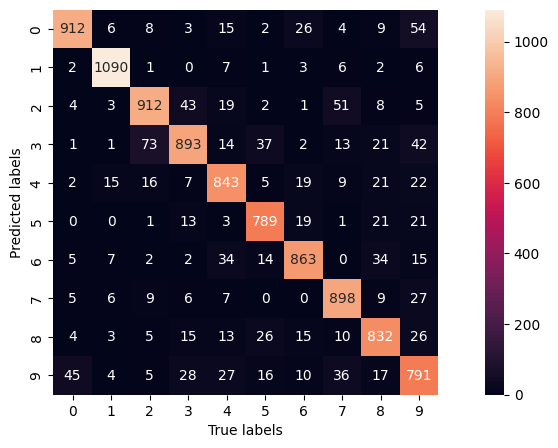

In [ ]:
mat_hog = confusion_matrix(test_labels, predictions_hog)

plt.figure(figsize = (12,5))

# Visualizing the confusion matrix as a heatmap
sns.heatmap(mat_hog.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

## Deep Feature Extraction

### Defining the Deep Neural Architecture (MLP)

Below is the link to pretrained Model. In the below notebook we have trained a Multi-Layer Perceptron for MNIST dataset and how the training and testing is performed using pytorch and we will also see how to save and load the trained model in pytorch.

https://colab.research.google.com/drive/19emQPby7KqGMD76fRBCwgk954gy5zfhL

Here, the neural network architecture takes 784(28x28) flattened inputs with 4 hidden layers having 512 neurons in each layer. The output layer has 10 outputs for for classifying 10 labels.

**Note:** The Pretrained model is loaded along with setup cells and is available for current run time.

In [ ]:
class Net_pretrained(nn.Module):
    def __init__(self):
        super(Net_pretrained, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, 512)   # Input layer with flattend input
        self.fc2 = nn.Linear(512, 512)      # Hidden layer with 512 neurons
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512,512)
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x3 = F.relu(self.fc3(x2))
        x4 = F.relu(self.fc4(x3))
        output = self.fc5(x4)
        return output, x4      # Returning output of output layer and hidden layer

#### Inferencing the pretrained model

In [ ]:
# Load the saved pretrained model path
PATH = '/content/pretrained_layer4_512n.pt'

# Instantiate the model
model_pretrained = Net_pretrained()

In [ ]:
# Load the saved pre-trained model
model_pretrained.load_state_dict(torch.load(PATH))

# Freeze the parameters
# This would prevent calculating the gradients for these parameters in the backward step
# which in turn prevents the optimizer from updating them
for param in model_pretrained.parameters():
    param.requires_grad = False

# Set the model to inference/evaluation stage
model_pretrained.eval()

Net_pretrained(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=10, bias=True)
)

#### Loading the MNIST Datset

In [ ]:
transform = transforms.ToTensor()

# how many samples per batch to load
batch_size = 1

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 439108925.08it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23645460.44it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 60669971.55it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17039828.95it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#### Extracting the deep features using pretrained model

In [ ]:
def get_features(image):
    model_pretrained.eval()
    _, deep_feature = model_pretrained(image)
    return deep_feature

#### Extracting deep features of training set

In [ ]:
deep_features_train = []
target_train = []
for data,target in train_loader:
    deep_features_train.append(get_features(data[0].squeeze()))
    target_train.append(target)

#### Extracting deep features of test set

In [ ]:
deep_features_test = []
target_test = []
for data,target in test_loader:
    deep_features_test.append(get_features(data[0].squeeze()))
    target_test.append(target)

In [ ]:
print(deep_features_train[0].shape) # shape of every row in training test

torch.Size([1, 512])


After generating deep features using pretrained model the deep features are 60000 tensors of size (1, 512)
`torch.cat` function concatenates the given sequence of tensors in the given dimension.So the deep features will now be of size (60000, 512) for training set and (10000, 512) for test set.

In [ ]:
# Concatenates the given sequence of tensors in the given dimension.
# All tensors must either have the same shape (except in the concatenating dimension) or be empty.
deep_features_train = torch.cat(deep_features_train, dim=0)
deep_features_test = torch.cat(deep_features_test, dim=0)

In [ ]:
print(deep_features_train.shape)  # after applying torch.cat() method

torch.Size([60000, 512])


#### Converting labels to numpy array

In [ ]:
target_train = np.array(target_train)
target_test = np.array(target_test)

#### Training the SVM using deep features

In [ ]:
def train(train_features, train_labels):

    # Create an instance for the LinearSVC classifier
    clf = svm.SVC(kernel='linear', random_state=0, max_iter=1000, probability=True)

    # Fitting the data into the model
    clf.fit(train_features, train_labels)

    return clf

#### Get the prediction on the test data

In [ ]:
def predict(clf, test_features):

    predictions = clf.predict(test_features)

    return predictions

#### Evaluation of accuracies using 'predictions' vs 'ground truth' or test_labels.

In [ ]:
def eval_deep_fe(predictions, test_labels):
    return accuracy_score(predictions, test_labels)

In [ ]:
# detach() - This operation detaches the tensor from the current computational graph.
# Now we cannot compute the gradient with respect to this tensor.
# After the detach() operation, we use the .numpy() method to convert it to a Numpy array
deep_features_train = deep_features_train.detach().numpy()
deep_features_test = deep_features_test.detach().numpy()

#### Split the deep features into train and validation set

In [ ]:
deep_features_train, deep_features_valid, y_train, y_valid = train_test_split(deep_features_train, target_train, test_size = 10000, random_state=42)

In [ ]:
y_train = y_train.astype('int')

In [ ]:
# Call the functions to train the classifier and get the predictions
# detach().numpy() will convert pytorch tensor to numpy array suitable for training
trained_deep_features = train(deep_features_train, y_train)

#### Evaluating the training loss

In [ ]:
# Compute probabilities of possible outcomes for samples in validation data
pred_train = trained_deep_features.predict_proba(deep_features_train)

# Compute cross-entropy loss
eval_train = log_loss(y_train, pred_train)
print(f"Loss in Training set is {eval_train}")

Loss in Training set is 0.007305148959107525


#### Evaluating the loss in validation set

In [ ]:
y_valid = y_valid.astype('int')

In [ ]:
pred_valid = trained_deep_features.predict_proba(deep_features_valid)
eval_valid = log_loss(y_valid, pred_valid)
print(f"Loss in Validation set is {eval_valid}")

Loss in Validation set is 0.009646394448439758


In [ ]:
target_test = target_test.astype('int')

### Get the prediction on test set

In [ ]:
predictions_deep_features = predict(trained_deep_features, deep_features_test)

# Calculate the accuracy
result = eval_deep_fe(predictions_deep_features, target_test)

In [ ]:
# Print the accuracy on Deep features
print('Accuracy score of Deep Learning features is:', result*100)

Accuracy score of Deep Learning features is: 97.89999999999999


#### Confusion Matrix for Predicted Label and True Label(Ground Truth).

In [ ]:
# Print the classification report
print(classification_report(target_test, predictions_deep_features))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



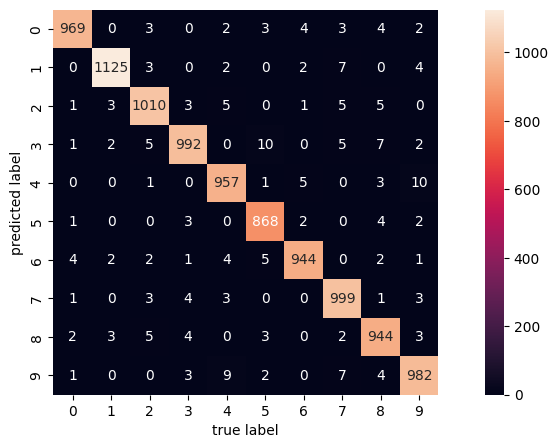

In [ ]:
mat_de_fe = confusion_matrix(target_test, predictions_deep_features)

plt.figure(figsize = (12,5))

# Visualizing the confusion matrix as a heatmap
sns.heatmap(mat_de_fe.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Summary

For Classical feature extraction using HOG and trained with SVM accuracy is 88%.

Using deep features generated using a pretrained neural network model and trained using SVM accuracy is 98%.

### Please answer the questions below to complete the experiment:




### Consider the below MLP network to answer Q1.

<center>

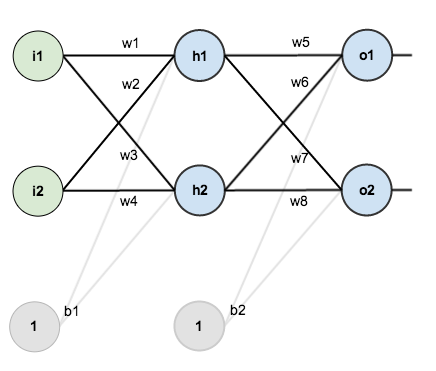
# </center>

In [ ]:
#@title Q.1. Calculate the MSE for above MLP network with inputs (i1, i2) = (0.05, 0.1), weights for layer h1 (w1, w2) = (0.15, 0.2), weights for layer h2 (w3, w4) = (0.25, 0.3), bias b1 = 0.35, b2 = 0.6, weights for o1 are (w5, w6) = (0.40, 0.45), weights for o2 are (w7, w8) = (0.50, 0.55) where o1 = 0.01and o2 = 0.99 are outputs of the network, given that the activation function is logistic sigmoid for both the layers ? { run: "auto", form-width: "500px", display-mode: "form" }
Answer1 = "0.012456" #@param ["","0.012456","0.298371","0.4687","1.00085"]


In [ ]:
#@title Q.2. Calculate the total gradient magnitude for HOG feature for below marked pixel?
Answer2 = "78.58" #@param ["","20.356","78.58","193.437","150.235"]


<center>

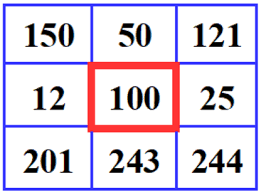
</center>


In [ ]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [ ]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "Nil" #@param {type:"string"}


In [ ]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [ ]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 1288
Date of submission:  29 Aug 2023
Time of submission:  19:31:30
View your submissions: https://dlfa-iisc.talentsprint.com/notebook_submissions
